# Data Gather

### **library imports**

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import csv
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import time
import os  # Add import for os module
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV, cross_val_score
from xgboost import XGBClassifier

### **Initialize MediaPipe Pose**

In [2]:
mp_pose = mp.solutions.pose  # Access MediaPipe's pose solution
mp_drawing = mp.solutions.drawing_utils  # Utility for drawing landmarks on frames
pose = mp_pose.Pose(
    static_image_mode=False,  # Process video frames in a continuous stream
    min_detection_confidence=0.5,  # Minimum confidence for detecting landmarks
    min_tracking_confidence=0.5  # Minimum confidence for tracking landmarks
)

### **Function to calculate the angle between two points in the XOY plane**

In [3]:
def angle_from_origin_xoy(p1, p2):
    delta_x = p2[0] - p1[0]
    delta_y = p1[1] - p2[1]  # Invert y-axis for Cartesian coordinates
                
    if delta_x == 0 and delta_y == 0:
        return 0.0  # Handle identical points
                
    angle = np.degrees(np.arctan2(delta_y, delta_x))
    angle = abs(angle)  # Convert -180 to -90 to 90 to 180
    if angle > 90:  # Second and third quadrants
        angle = 180 - angle  # Map 90-180 to 90-0            
    return angle

### **Function to process video and calculate angles**

In [4]:
def process_video_and_calculate_angles(video_path, landmark_to_compare,landmark_name, classification_class):
    """
    Process a video to calculate angles between a reference point and a specified landmark.
    Args:
        video_path (str): Path to the input video file.
        landmark_to_compare (int): Index of the landmark to compare against the reference point.
    """

    #Calculate angles and store them
    angles_data = []
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video.")
        return

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    scale = (800, 600)
    frame_atual = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame is None:
            print("End of video or cannot read the frame.")
            break

        imagem_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resultado = pose.process(imagem_rgb)

        if resultado.pose_landmarks:
            mp_drawing.draw_landmarks(frame, resultado.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            # Get reference point (midpoint between hips)
            left_hip = resultado.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP]
            right_hip = resultado.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]
            ref_x = (left_hip.x + right_hip.x) / 2
            ref_y = (left_hip.y + right_hip.y) / 2

            # Use the index directly to get the specified landmark
            target_landmark = resultado.pose_landmarks.landmark[int(landmark_to_compare)]

            # Convert normalized coordinates to image coordinates
            h, w, _ = frame.shape
            ref_pt = (int(ref_x * w), int(ref_y * h))
            target_pt = (int(target_landmark.x * w), int(target_landmark.y * h))

            # Draw points
            cv2.circle(frame, ref_pt, 8, (0, 255, 0), -1)
            cv2.circle(frame, target_pt, 8, (0, 0, 255), -1)

            # Draw line
            cv2.line(frame, ref_pt, target_pt, (255, 255, 0), 2)

            # Calculate angle
            angulo = angle_from_origin_xoy(ref_pt, target_pt)

            if angulo is not None:
                # Save the angle and frame number to the list
                angles_data.append((frame_atual, angulo,classification_class))

                # Display angle
                cv2.putText(frame, f"Angle: {angulo:.1f} deg", (target_pt[0]+10, target_pt[1]-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)
            else:
                # Log a message if the angle is None
                print(f"Frame {frame_atual}: Unable to calculate angle.")

        frame_resized = cv2.resize(frame, scale)
        cv2.imshow("Angle Visualization", frame_resized)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_atual += 1
    cap.release()
    cv2.destroyAllWindows()
    
    csv_path = f"{video_path}_{landmark_name}_angles.csv"
    # Save angles and frame numbers to a CSV file
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Frame", "Angle (degrees)", "Classification"])
        writer.writerows(angles_data)

    print(f"Angles and frame numbers saved to {csv_path}")


### **Function to process csv and normalize data**

In [5]:
def analyze_csv(csv_file_path): # type: ignore
    """
    Analyze the CSV file to filter angles, calculate velocity, and acceleration.
    Args:
        csv_file_path (str): Path to the input CSV file.
        output_file_path (str): Path to save the processed CSV file.
    """
    # Load the CSV file
    data = pd.read_csv(csv_file_path)

    # Butterworth low-pass filter function
    def butter_lowpass_filter(data, cutoff, fs, order):
        b, a = butter(order, cutoff, btype='low', analog=False)
        return filtfilt(b, a, data)

    # Define filter parameters
    order = 4
    cutoff = 0.2
    fps = 30

    # Apply the filter to the Angle (degrees) column
    data['Filtered Angle (degrees)'] = butter_lowpass_filter(data['Angle (degrees)'], cutoff, fps, order)

    # Calculate velocity and acceleration
    data['velocity'] = np.gradient(data['Filtered Angle (degrees)'], data['Frame'])
    data['acceleration'] = np.gradient(data['velocity'], data['Frame'])

    # Normalize velocity and acceleration
    scaler = MinMaxScaler()
    data[['velocity_normalized', 'acceleration_normalized']] = scaler.fit_transform(
        data[['velocity', 'acceleration']]
    )

    # Add a new column to convert frames to seconds
    data['Time (seconds)'] = data['Frame'] / fps

    # Save the updated DataFrame to a new CSV file
    data.to_csv(csv_file_path+"_processed", index=False)
    print("Processed data saved to " + csv_file_path + "_processed.csv")

### **Define the landmarks of interest**

In [6]:
landmarks_ids = {
    "head": 0,  # Head (nose landmark)
    "left_wrist": 15,  # Left wrist
    "right_wrist": 16,  # Right wrist
    "left_ankle": 27,  # Left ankle
    "right_ankle": 28  # Right ankle
}
print("Landmarks de interesse definidos:", landmarks_ids)


Landmarks de interesse definidos: {'head': 0, 'left_wrist': 15, 'right_wrist': 16, 'left_ankle': 27, 'right_ankle': 28}


### **Gather data from videos**

In [7]:
videos = {
    '.\\Videos\\impro_free.MP4': 'direct',
    '.\\Videos\\Phrase3.mp4': 'indirect',
}

def calculate_landmarks_for_videos(videos, landmarks):
    for video_path, classification in videos.items():
        for landmark_name, landmark_index in landmarks.items():
            process_video_and_calculate_angles(video_path, landmark_index, landmark_name, classification)
            analyze_csv(csv_file_path=f"{video_path}_{landmark_name}_angles.csv")

calculate_landmarks_for_videos(videos, landmarks_ids)

End of video or cannot read the frame.
Angles and frame numbers saved to .\Videos\impro_free.MP4_head_angles.csv
Processed data saved to .\Videos\impro_free.MP4_head_angles.csv_processed.csv
End of video or cannot read the frame.
Angles and frame numbers saved to .\Videos\impro_free.MP4_left_wrist_angles.csv
Processed data saved to .\Videos\impro_free.MP4_left_wrist_angles.csv_processed.csv
End of video or cannot read the frame.
Angles and frame numbers saved to .\Videos\impro_free.MP4_right_wrist_angles.csv
Processed data saved to .\Videos\impro_free.MP4_right_wrist_angles.csv_processed.csv
End of video or cannot read the frame.
Angles and frame numbers saved to .\Videos\impro_free.MP4_left_ankle_angles.csv
Processed data saved to .\Videos\impro_free.MP4_left_ankle_angles.csv_processed.csv
End of video or cannot read the frame.
Angles and frame numbers saved to .\Videos\impro_free.MP4_right_ankle_angles.csv
Processed data saved to .\Videos\impro_free.MP4_right_ankle_angles.csv_process

### **Join all processed CSV files from the videos folder**

In [8]:
import glob
video_folder = os.path.dirname(list(videos.keys())[0])
processed_csv_paths = glob.glob(os.path.join(video_folder, "*processed"))

print(f"Found {len(processed_csv_paths)} processed CSV files.")

# Read and concatenate all processed CSVs into a single DataFrame
df_all_processed = pd.concat([pd.read_csv(csv) for csv in processed_csv_paths], ignore_index=True)
print(f"Total rows in combined DataFrame: {len(df_all_processed)}")
df_all_processed.head()

Found 10 processed CSV files.
Total rows in combined DataFrame: 3105


,Frame,Angle (degrees),Classification,Filtered Angle (degrees),velocity,acceleration,velocity_normalized,acceleration_normalized,Time (seconds)
0,0,88.657376,direct,88.632541,-0.773974,-0.202624,0.415355,0.379915,0.000000
1,1,88.809610,direct,87.858567,-0.976598,-0.362336,0.396622,0.301546,0.033333
2,2,90.000000,direct,86.679346,-1.498647,-0.567774,0.348357,0.200740,0.066667
3,3,86.845157,direct,84.861274,-2.112145,-0.519846,0.291638,0.224258,0.100000
4,4,83.115721,direct,82.455056,-2.538338,-0.225623,0.252235,0.368630,0.133333


### **Save the concatenated DataFrame to a new CSV file**

In [9]:
output_csv_path = os.path.join(video_folder, "all_landmarks_processed_combined.csv")
df_all_processed.to_csv(output_csv_path, index=False)
print(f"Combined CSV saved to: {output_csv_path}")

Combined CSV saved to: .\Videos\all_landmarks_processed_combined.csv


### **Print DataFrame statistics**

In [10]:
df_all_processed.describe(include='all')

,Frame,Angle (degrees),Classification,Filtered Angle (degrees),velocity,acceleration,velocity_normalized,acceleration_normalized,Time (seconds)
count,3105.000000,3105.000000,3105,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,indirect,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,2054,NaN,NaN,NaN,NaN,NaN,NaN
mean,188.083736,63.380930,NaN,63.379044,-0.044273,-0.011939,0.498049,0.460475,6.269458
std,130.052339,25.684196,NaN,24.763735,2.915445,1.001926,0.151408,0.149566,4.335078
min,0.000000,0.000000,NaN,-0.708321,-12.947071,-5.243074,0.000000,0.000000,0.000000
25%,78.000000,45.964484,NaN,44.996007,-0.878904,-0.256035,0.442420,0.395970,2.600000
50%,171.000000,75.454797,NaN,75.189565,-0.016241,-0.015270,0.504958,0.446841,5.700000
75%,286.000000,82.528441,NaN,82.102279,0.793437,0.182126,0.564477,0.534612,9.533333


In [11]:
df_all_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3105 entries, 0 to 3104
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Frame                     3105 non-null   int64  
 1   Angle (degrees)           3105 non-null   float64
 2   Classification            3105 non-null   object 
 3   Filtered Angle (degrees)  3105 non-null   float64
 4   velocity                  3105 non-null   float64
 5   acceleration              3105 non-null   float64
 6   velocity_normalized       3105 non-null   float64
 7   acceleration_normalized   3105 non-null   float64
 8   Time (seconds)            3105 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 218.4+ KB


# Training

### **Necessary Imports**

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

### **Gather all processed CSVs and Split Data for Training**

In [13]:
csv_files = []
for video_path, _ in videos.items():
    for landmark_name in landmarks_ids.keys():
        if landmark_name == 'left_wrist':
            # Ensure the processed CSV file exists before appending
            if os.path.exists(f"{video_path}_{landmark_name}_angles.csv_processed"):
              print(f"{video_path}_{landmark_name}_angles.csv_processed")  
              csv_files.append(f"{video_path}_{landmark_name}_angles.csv_processed")

# Concatenate all processed CSVs into a single DataFrame
df_list = [pd.read_csv(csv) for csv in csv_files]
df_all = pd.concat(df_list, ignore_index=True)

# Features and target
X = df_all[['Filtered Angle (degrees)', 'velocity_normalized', 'acceleration_normalized']]
y = df_all['Classification']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

.\Videos\impro_free.MP4_left_wrist_angles.csv_processed
.\Videos\Phrase3.mp4_left_wrist_angles.csv_processed


### **Create and Build Model**

In [14]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and report
y_pred = rf.predict(X_test)

### **Test Model**

              precision    recall  f1-score   support

      direct       0.57      0.48      0.52        42
    indirect       0.76      0.82      0.79        83

    accuracy                           0.70       125
   macro avg       0.66      0.65      0.65       125
weighted avg       0.69      0.70      0.70       125



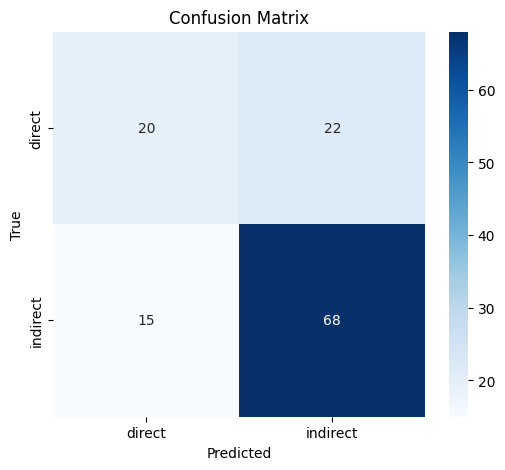

Feature Importances:
acceleration_normalized: 0.3786
velocity_normalized: 0.3114
Filtered Angle (degrees): 0.3100


C:\Users\asus\AppData\Local\Temp\ipykernel_30836\511351462.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")


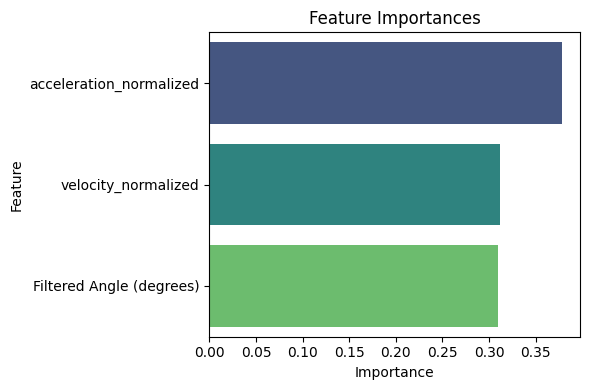

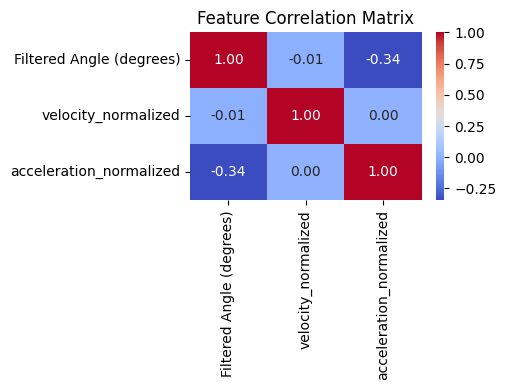

In [15]:
print(classification_report(y_test, y_pred))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Plot feature importances
plt.figure(figsize=(6, 4))
sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

# Plot correlation matrix of features
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [16]:
# Add rolling statistics features
df_all['rolling_mean_angle'] = df_all['Filtered Angle (degrees)'].rolling(window=5).mean()
df_all['rolling_std_angle'] = df_all['Filtered Angle (degrees)'].rolling(window=5).std()
df_all['rolling_mean_velocity'] = df_all['velocity_normalized'].rolling(window=5).mean()
df_all['rolling_std_velocity'] = df_all['velocity_normalized'].rolling(window=5).std()

In [17]:
# Separate classes
df_direct = df_all[df_all['Classification'] == 'direct']
df_indirect = df_all[df_all['Classification'] == 'indirect']

# Resample to balance classes
df_direct_resampled = resample(df_direct, replace=True, n_samples=len(df_indirect), random_state=42)
df_balanced = pd.concat([df_direct_resampled, df_indirect])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

### **Create and Build Model with Hyperparameter Tuning**

In [18]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Use the best model
rf = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Predict and report
y_pred = rf.predict(X_test)

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


### **Test Model with Hyperparameter Tuning**

              precision    recall  f1-score   support

      direct       0.53      0.40      0.46        42
    indirect       0.73      0.82      0.77        83

    accuracy                           0.68       125
   macro avg       0.63      0.61      0.62       125
weighted avg       0.66      0.68      0.67       125



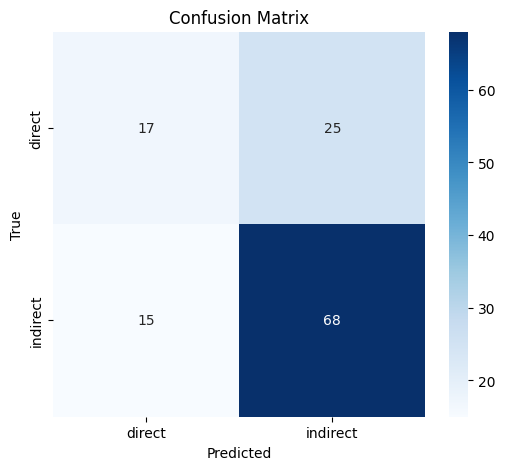

Feature Importances:
acceleration_normalized: 0.3755
Filtered Angle (degrees): 0.3136
velocity_normalized: 0.3109


C:\Users\asus\AppData\Local\Temp\ipykernel_30836\1907170430.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")


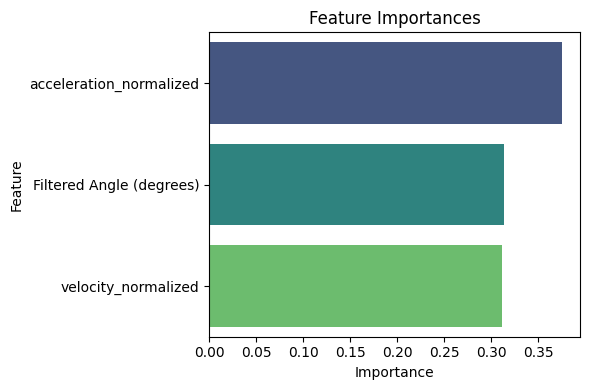

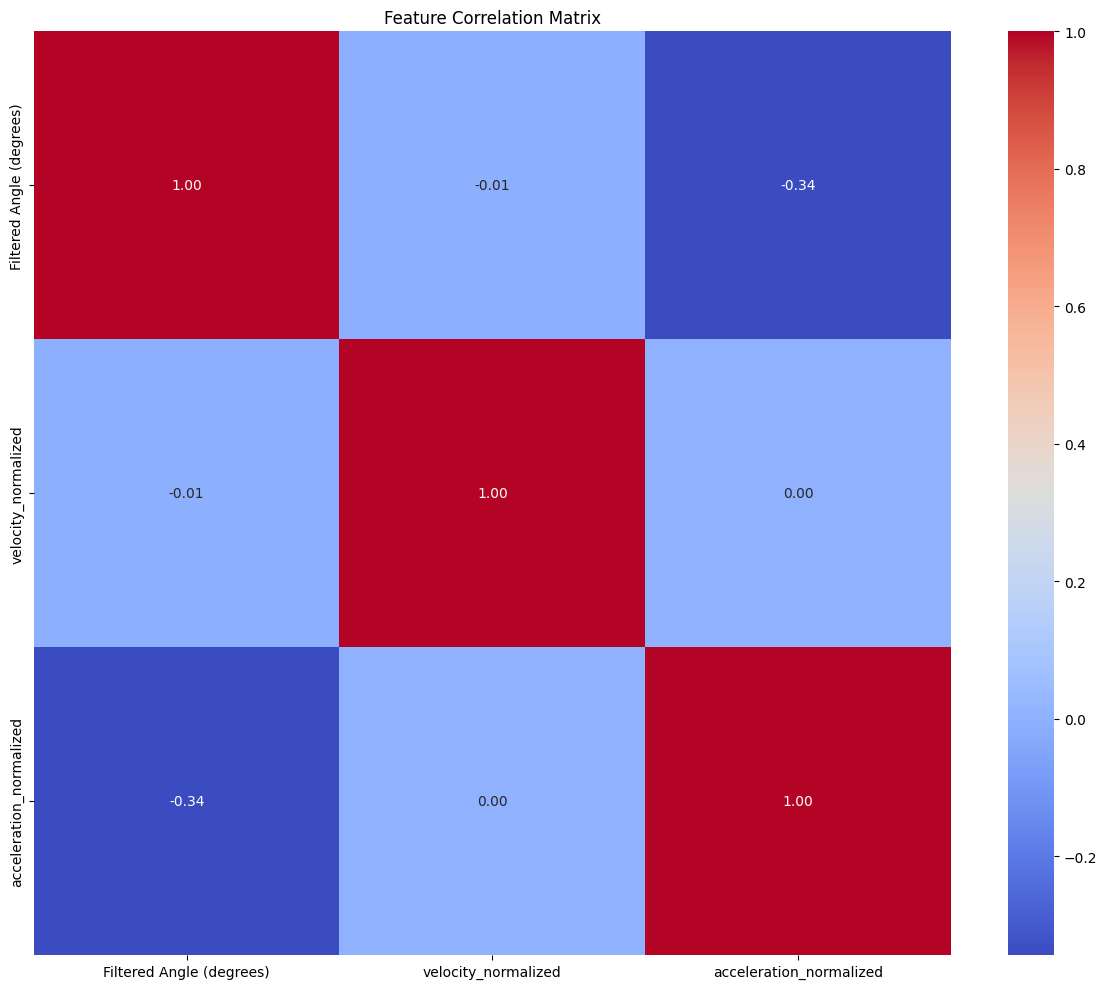

In [19]:
print(classification_report(y_test, y_pred))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Plot feature importances
plt.figure(figsize=(6, 4))
sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

# Plot correlation matrix of features
plt.figure(figsize=(12, 10))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

### **Try XGBoost Model**

              precision    recall  f1-score   support

      direct       0.54      0.50      0.52        42
    indirect       0.76      0.78      0.77        83

    accuracy                           0.69       125
   macro avg       0.65      0.64      0.64       125
weighted avg       0.68      0.69      0.68       125



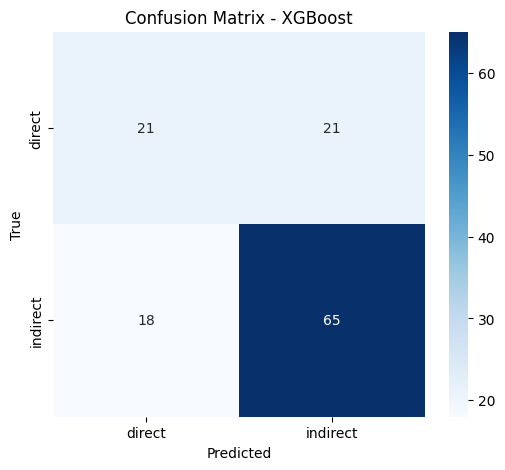

Feature Importances (XGBoost):
acceleration_normalized: 0.4147
Filtered Angle (degrees): 0.3104
velocity_normalized: 0.2748


C:\Users\asus\AppData\Local\Temp\ipykernel_30836\1569712675.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")


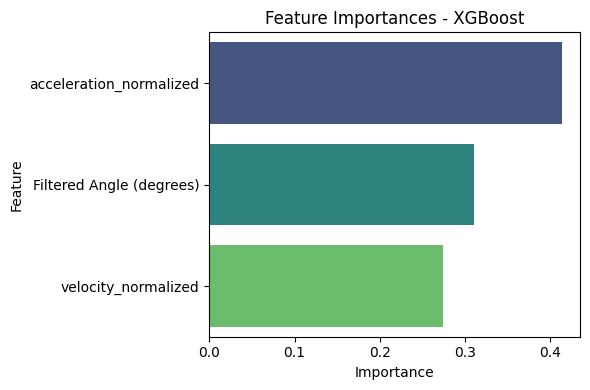

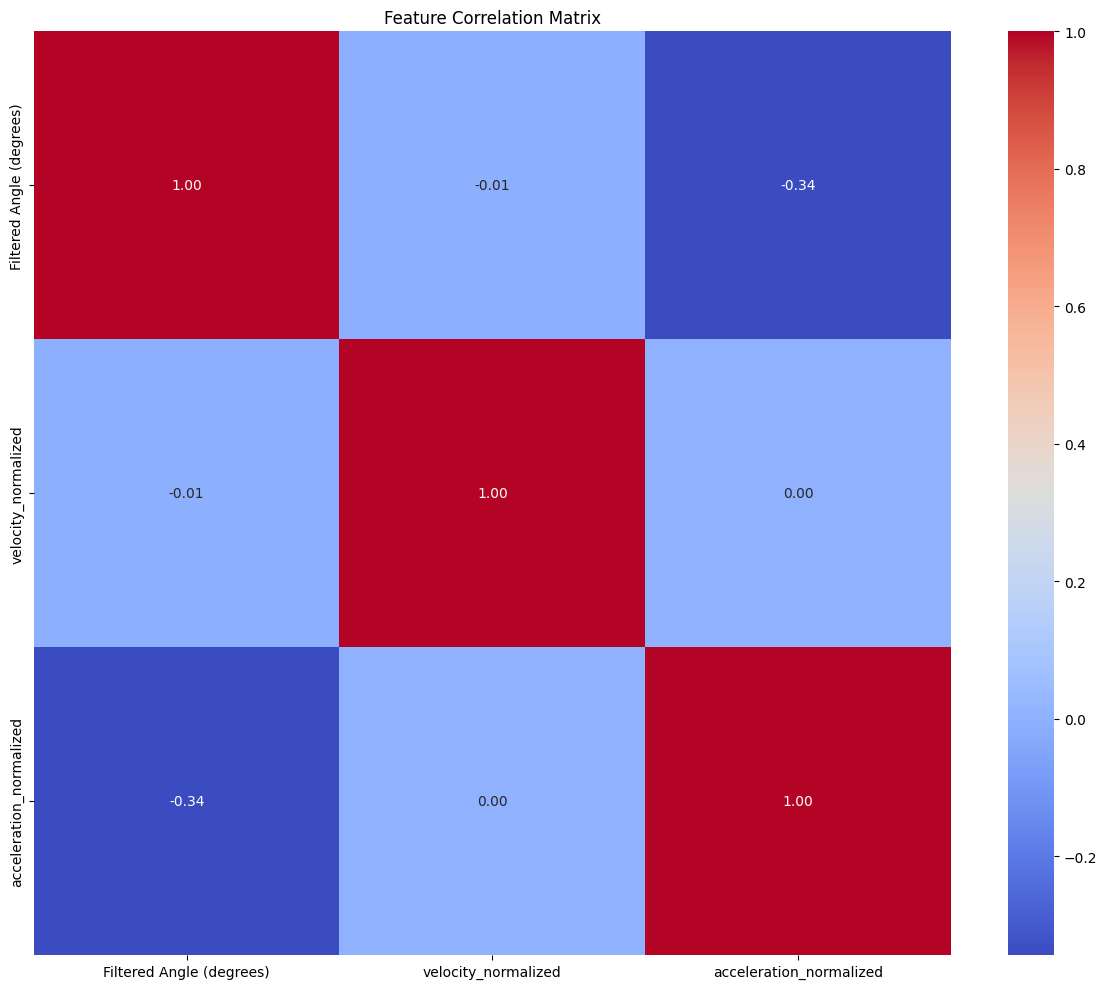

In [20]:
# Encode target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train XGBoost
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb.fit(X_train, y_train_encoded)

# Predict and evaluate
y_pred_encoded = xgb.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print(classification_report(y_test, y_pred))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# Feature importances
importances = xgb.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances (XGBoost):")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Plot feature importances
plt.figure(figsize=(6, 4))
sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances - XGBoost")
plt.tight_layout()
plt.show()

# Plot correlation matrix of features
plt.figure(figsize=(12, 10))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()